<a href="https://colab.research.google.com/github/s183796/AIStudentProjects/blob/cullen/OptimizingTrainingSize_InclusionOfPlots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from typing import *
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
import numpy as np
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
from torch.nn.functional import softmax
import PIL.Image
import os
import torchvision
import cv2

from torchvision import transforms
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, Dataset, Subset

import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms.functional as TF
import glob

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install albumentations

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2


In [ ]:
class UNet(nn.Module): #from https://towardsdatascience.com/cook-your-first-u-net-in-pytorch-b3297a844cf3
    def __init__(self, n_class):
        super().__init__()

        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image.
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 1x128x128
        self.e11 = nn.Conv2d(1, 64, kernel_size=3,padding=1)
        self.e12 = nn.Conv2d(64, 64, kernel_size=3,padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) #64x64x64

        self.e21 = nn.Conv2d(64, 128, kernel_size=3,padding=1)
        self.e22 = nn.Conv2d(128, 128, kernel_size=3,padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) #32x32x128

        self.e31 = nn.Conv2d(128, 256, kernel_size=3,padding=1)
        self.e32 = nn.Conv2d(256, 256, kernel_size=3,padding=1)

        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) #16x16x256

        self.e41 = nn.Conv2d(256, 512, kernel_size=3,padding=1)
        self.e42 = nn.Conv2d(512, 512, kernel_size=3,padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) #8x8x512

        self.e51 = nn.Conv2d(512, 1024, kernel_size=3,padding=1)
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3,padding=1)

        self.upconv1 = nn.ConvTranspose2d(1024,512,kernel_size=2,stride=2) #16x16x1024
        self.d11 = nn.Conv2d(1024,512,kernel_size=3,padding=1)
        self.d12 = nn.Conv2d(512,512,kernel_size=3,padding=1)

        self.upconv2 = nn.ConvTranspose2d(512,256,kernel_size=2,stride=2) #
        self.d21 = nn.Conv2d(512,256,kernel_size=3,padding=1)
        self.d22 = nn.Conv2d(256,256,kernel_size=3,padding=1)

        self.upconv3 = nn.ConvTranspose2d(256,128,kernel_size=2,stride=2)
        self.d31 = nn.Conv2d(256,128,kernel_size=3,padding=1)
        self.d32 = nn.Conv2d(128,128,kernel_size=3,padding=1)

        self.upconv4 = nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)
        self.d41 = nn.Conv2d(128,64,kernel_size=3,padding=1)
        self.d42 = nn.Conv2d(64,64,kernel_size=3,padding=1)

        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = F.relu(self.e11(x))
        xe12 = F.relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = F.relu(self.e21(xp1))
        xe22 = F.relu(self.e22(xe21))
        xp2 = self.pool2(xe22)


        xe31 = F.relu(self.e31(xp2))
        xe32 = F.relu(self.e32(xe31))


        xp3 = self.pool3(xe32)

        xe41 = F.relu(self.e41(xp3))
        xe42 = F.relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = F.relu(self.e51(xp4))
        xe52 = F.relu(self.e52(xe51))

        # Up-convolutions
        xup1 = self.upconv1(xe52)

        xcat = torch.cat([xup1, xe42], dim=1)

        xup21 = F.relu(self.d11(xcat))
        xup22 = F.relu(self.d12(xup21))

        xup2 = self.upconv2(xup22)

        #xcat2 = torch.cat([xup2, xe32[:,:,:-1,:-1]], dim=1)
        xcat2 = torch.cat([xup2, xe32], dim=1)


        xup31 = F.relu(self.d21(xcat2))
        xup32 = F.relu(self.d22(xup31))
        xup3 = self.upconv3(xup32)
        xcat3 = torch.cat([xup3, xe22], dim=1)

        xup41 = F.relu(self.d31(xcat3))
        xup42 = F.relu(self.d32(xup41))

        xup4 = self.upconv4(xup42)
        #xcat4 = torch.cat([xup4, xe12[:,:,2:-3,2:-3]], dim=1)
        xcat4 = torch.cat([xup4, xe12], dim=1)
        xup51 = F.relu(self.d41(xcat4))
        xup52 = F.relu(self.d42(xup51))

        out = self.outconv(xup52)

        output = softmax(out,dim=1)

        return output

In [ ]:
#Setting up hyper parameters, from exercise week 6


loss_fn =  nn.CrossEntropyLoss()         # <-- Your code here.

import random


In [ ]:
class SOCDataset(Dataset):
    def __init__(self, root_dir, transform=None,transform_flip=None):
        self.root_dir = root_dir
        self.image_folder = os.path.join(root_dir, 'data/')
        self.label_folder = os.path.join(root_dir, 'labels/')
        self.transform = transform
        self.transform_flip = transform_flip

        self.image_filenames = sorted([f for f in os.listdir(self.image_folder) if f.endswith('.tiff')][:300])
        self.label_filenames = sorted([f for f in os.listdir(self.label_folder) if f.endswith('.tif')][:300])
        # self.image_filenames = sorted([f for f in os.listdir(self.image_folder) if f.endswith('.tiff')])
        # self.label_filenames = sorted([f for f in os.listdir(self.label_folder) if f.endswith('.tif')])
    def _set_seed(self, seed):
        random.seed(seed)
        torch.manual_seed(seed)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
      img_name = os.path.join(self.image_folder, self.image_filenames[idx])
      #label_name = os.path.join(self.label_folder, self.label_filenames[idx])
      #assert img_name[-8:-5] != label_name[-7:-4], f"Not corresponding label and image {img_name[-8:-5]}, {label_name[-7:-4]}"

      number1=img_name[-8:-5]
      label_name=os.path.join(self.label_folder,'slice__'+str(number1)+'.tif')

      image = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
      label = cv2.imread(label_name, cv2.IMREAD_GRAYSCALE)

      image=np.array(image)
      label=np.array(label)

      if self.transform is not None:
        augmentations=self.transform(image=image,mask=label)

      image=augmentations["image"]
      label=augmentations["mask"]

      return image, label

In [ ]:

# transform = A.Compose(
#     [A.HorizontalFlip(p=0.5),
#      A.RandomCrop(width=128,height=128),
#      A.VerticalFlip(p=0.1),
#      A.Normalize(
#         mean=[0.5],
#         std=[0.5],
#         max_pixel_value=255.0,),
#     ToTensorV2(),

#      ]
# )
transform = A.Compose(
    [
     A.HorizontalFlip(p=0.5),
     A.RandomCrop(width=128, height=128),
     A.VerticalFlip(p=0.1),
     A.RandomBrightnessContrast(p=0.2),  # Adjust brightness/contrast
     A.GaussNoise(p=0.2),  # Add Gaussian noise
     A.Resize(64, 64, p=0.2),  # Downsample to 64x64
     A.Resize(128, 128),  # Upsample back to 128x128
     A.Normalize(
        mean=[0.5],
        std=[0.5],
        max_pixel_value=255.0,
     ),
     ToTensorV2(),
    ]
)



In [ ]:
SOC_dataset = SOCDataset(root_dir='drive/My Drive//AI data/', transform = transform)


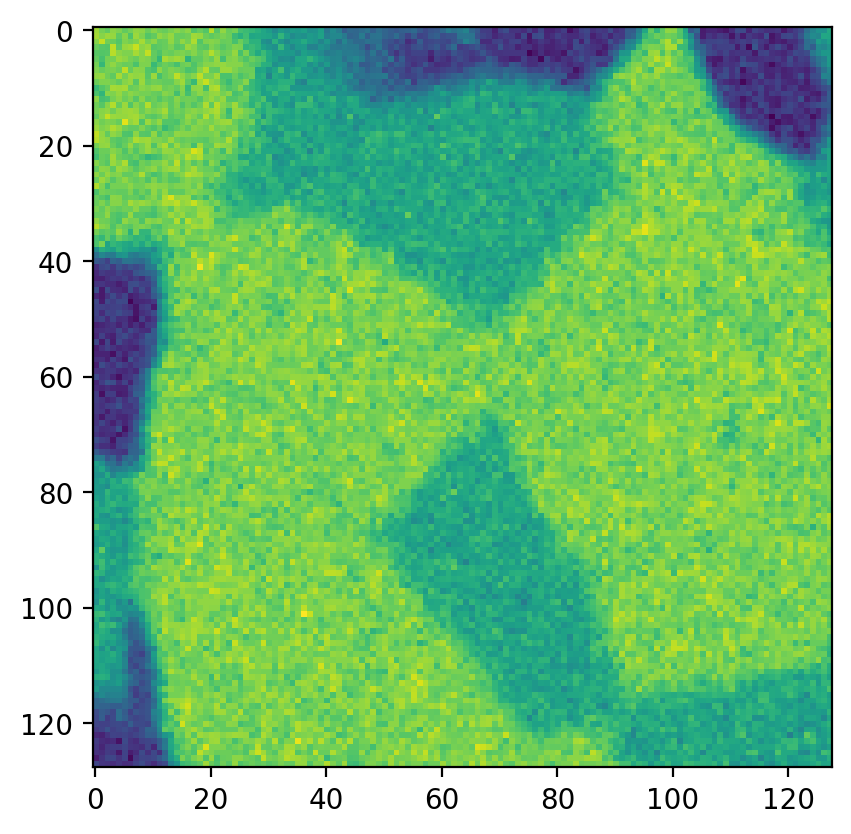

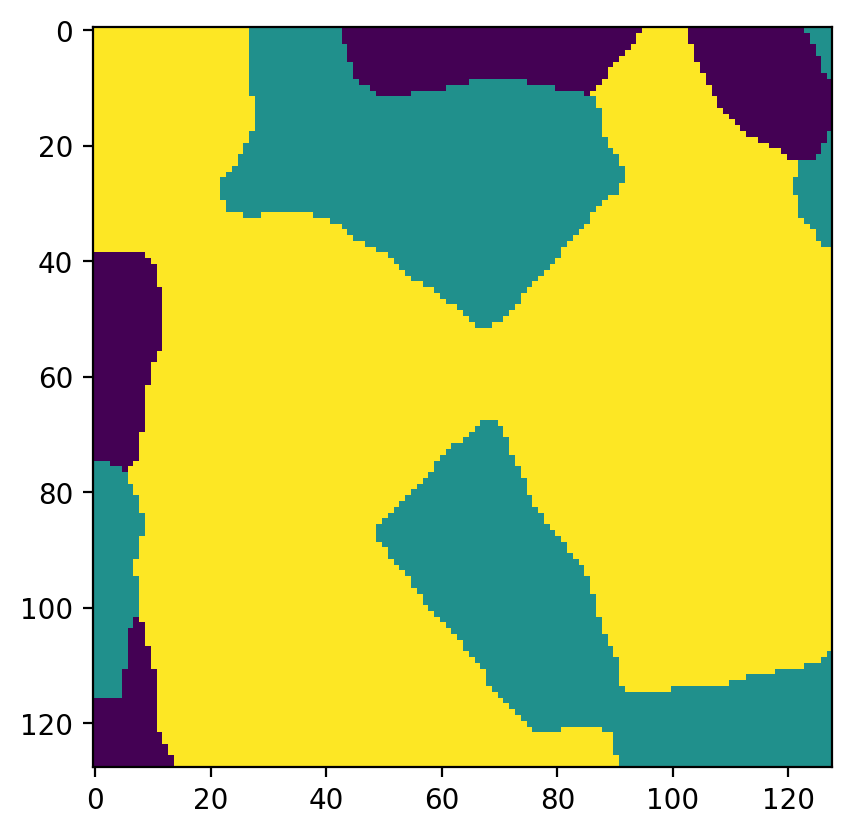

In [ ]:
image,label=SOC_dataset[33]

plt.figure(dpi=200)
plt.imshow(image[0,:,:])

plt.figure(dpi=200)
plt.imshow(label)

In [ ]:
pip install torchmetrics

In [ ]:
from torchmetrics.classification import JaccardIndex

In [ ]:
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.3
BATCH_SIZE = 16
SEED = 42

# generate indices: instead of the actual data we pass in integers instead
train_indices, test_indices = train_test_split(
    range(len(SOC_dataset)),
    test_size=TEST_SIZE,
    random_state=SEED
)

val_indices, test_indices = train_test_split(
    test_indices,
    test_size=0.5,
    random_state=SEED
)

# generate subset based on indices
train_split = Subset(SOC_dataset, train_indices)
test_split = Subset(SOC_dataset, test_indices)
val_split = Subset(SOC_dataset, val_indices)

# create batches
train_loader = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_split, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_split, batch_size=BATCH_SIZE)

In [ ]:
net=UNet(n_class=3)

from torchmetrics.functional.classification import dice
from torchmetrics.classification import MulticlassAccuracy
#metric=Dice(num_classes=3)


optimizer = optim.Adam(net.parameters(), lr=0.0001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

jaccard=JaccardIndex(task="multiclass", num_classes=3).to(device)
accuracy=MulticlassAccuracy(num_classes=3).to(device)
batch_size = 16
num_epochs = 25 #changing the num_epochs from 2 to 12
validation_every_steps = 10

step = 0
net.train()

train_accuracies_jaccard = []
train_accuracies_dice = []
train_accuracies_pixel = []
valid_accuracies_jaccard = []
valid_accuracies_dice = []
valid_accuracies_pixel = []

for epoch in range(num_epochs):

    train_accuracies_batches_jaccard = []
    train_accuracies_batches_dice = []
    train_accuracies_batches_pixel = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass, compute gradients, perform one training step.
        # Your code here!
        # Forward pass.
        output = net(inputs)

        un_target=targets.unique()
        # Compute loss.
        targets[targets==un_target[0]]=0
        targets[targets==un_target[1]]=1
        targets[targets==un_target[2]]=2

        targets = targets.to(torch.int64)

        loss = loss_fn(output, targets)

        # Clean up gradients from the model.
        optimizer.zero_grad()

        # Compute gradients based on the loss from the current batch (backpropagation).
        loss.backward()

        # Take one optimizer step using the gradients computed in the previous step.
        optimizer.step()

        # Increment step counter
        step += 1

        # Compute accuracy.
        predictions = torch.argmax(output,dim=1)
        train_accuracies_batches_dice.append(dice(predictions,targets).cpu())
        train_accuracies_batches_jaccard.append(jaccard(predictions,targets).cpu())
        train_accuracies_batches_pixel.append(accuracy(predictions,targets).cpu())

        if step % validation_every_steps == 0:

            # Append average training accuracy to list.
            train_accuracies_jaccard.append(np.mean(train_accuracies_batches_jaccard))
            train_accuracies_dice.append(np.mean(train_accuracies_batches_dice))
            train_accuracies_pixel.append(np.mean(train_accuracies_batches_pixel))

            train_accuracies_batches_jaccard = []
            train_accuracies_batches_dice = []
            train_accuracies_batches_pixel = []

            # Compute accuracies on validation set.
            valid_accuracies_batches_jaccard = []
            valid_accuracies_batches_dice = []
            valid_accuracies_batches_pixel = []
            with torch.no_grad():
                net.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = net(inputs)

                    un_target=targets.unique()
                    # Compute loss.
                    targets[targets==un_target[0]]=0
                    targets[targets==un_target[1]]=1
                    targets[targets==un_target[2]]=2

                    targets = targets.to(torch.int64)

                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]
                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches_dice.append(dice(predictions,targets).cpu())
                    valid_accuracies_batches_jaccard.append(jaccard(predictions,targets).cpu())
                    valid_accuracies_batches_pixel.append(accuracy(predictions,targets).cpu())

                net.train()

            # Append average validation accuracy to list.
            valid_accuracies_jaccard.append(np.sum(valid_accuracies_batches_jaccard) / len(test_loader))
            valid_accuracies_dice.append(np.sum(valid_accuracies_batches_dice) / len(test_loader))
            valid_accuracies_pixel.append(np.sum(valid_accuracies_batches_pixel) / len(test_loader))

            print(f"Step {step:<5}   training accuracy with jaccard: {train_accuracies_jaccard[-1]}")
            print(f"             training accuracy with dice: {train_accuracies_dice[-1]}")
            print(f"             training accuracy with pixel by pixel: {train_accuracies_pixel[-1]}")
            print(f"             test accuracy with jaccard: {valid_accuracies_jaccard[-1]}")
            print(f"             test accuracy with dice: {valid_accuracies_dice[-1]}")
            print(f"             test accuracy with pixel by pixel: {valid_accuracies_pixel[-1]}")


print("Finished training.")

Step 10      training accuracy with jaccard: 0.14374032616615295
             training accuracy with dice: 0.43122100830078125
             training accuracy with pixel by pixel: 0.3333333134651184
             test accuracy with jaccard: 0.13973402976989746
             test accuracy with dice: 0.4192020893096924
             test accuracy with pixel by pixel: 0.3333333333333333
Step 20      training accuracy with jaccard: 0.13831757009029388
             training accuracy with dice: 0.40768495202064514
             training accuracy with pixel by pixel: 0.3360781967639923
             test accuracy with jaccard: 0.159799853960673
             test accuracy with dice: 0.4256463845570882
             test accuracy with pixel by pixel: 0.354894757270813
Step 30      training accuracy with jaccard: 0.512360155582428
             training accuracy with dice: 0.6874103546142578
             training accuracy with pixel by pixel: 0.6410388946533203
             test accuracy with jaccard: 0

Step 120     
training accuracy with jaccard: 0.8931217193603516   
             training accuracy with dice: 0.9431208372116089   
             training accuracy with pixel by pixel: 0.9395834803581238   
             test accuracy with jaccard: 0.8932232856750488   
             test accuracy with dice: 0.9425252079963684   
             test accuracy with pixel by pixel: 0.9364344477653503   

In [ ]:
val_acc_dice=[]
val_acc_jaccard=[]
val_acc_pixel=[]

for inputs, targets in val_loader:
  inputs, targets = inputs.to(device), targets.to(device)
  output = net(inputs)
  un_target=targets.unique()
  # Compute loss.
  targets[targets==un_target[0]]=0
  targets[targets==un_target[1]]=1
  targets[targets==un_target[2]]=2

  targets = targets.to(torch.int64)

  predictions = output.max(1)[1]

  val_acc_dice.append(dice(predictions,targets))
  val_acc_jaccard.append(jaccard(predictions,targets))
  val_acc_pixel.append(accuracy(predictions,targets))


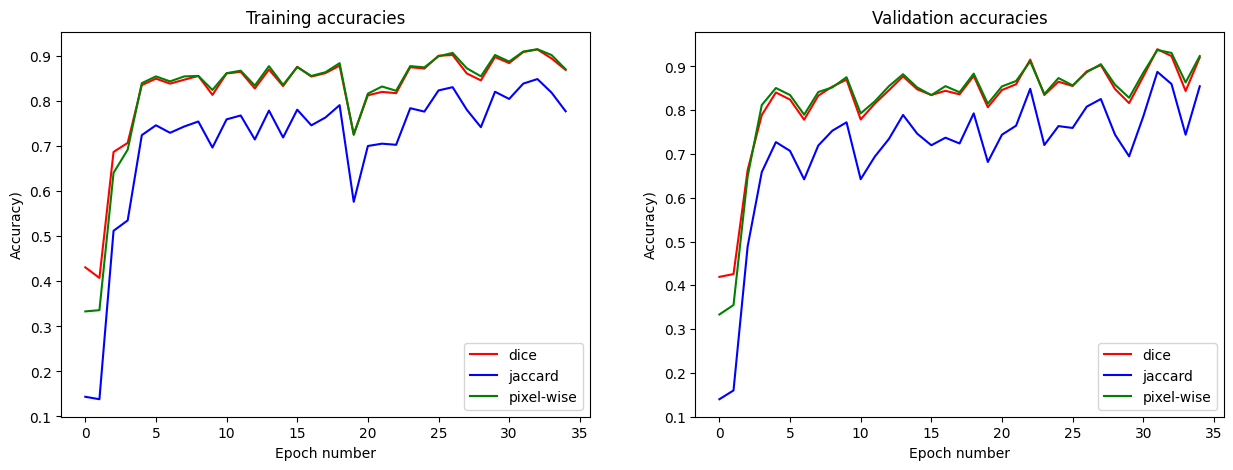

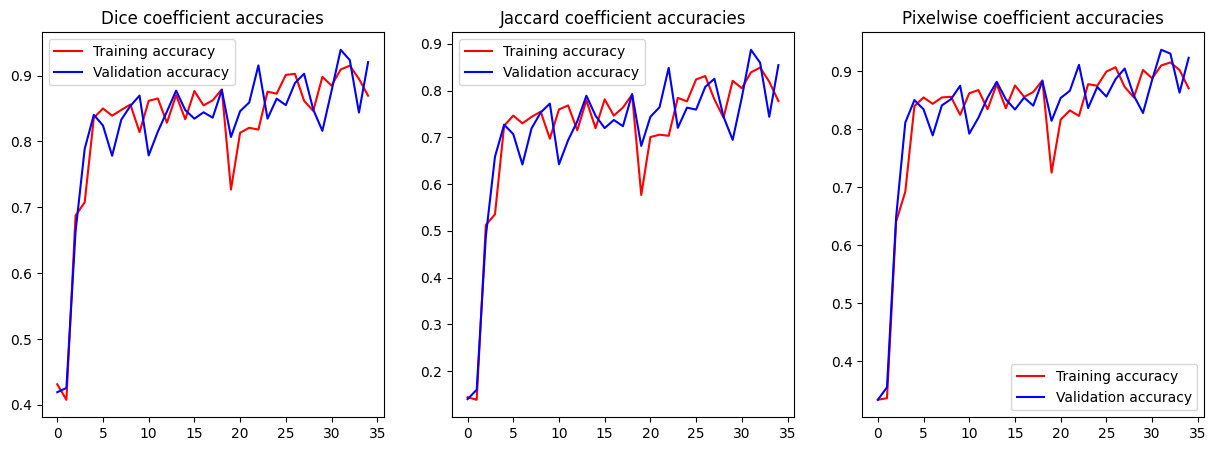

In [ ]:
fig,axs=plt.subplots(1,2,figsize=(15,5))
axs[0].plot(train_accuracies_dice,color='red',label='dice')
axs[0].plot(train_accuracies_jaccard,color='blue',label='jaccard')
axs[0].plot(train_accuracies_pixel,color='green',label='pixel-wise')
axs[0].legend()
axs[0].set_title('Training accuracies')
axs[0].set_xlabel('Epoch number')
axs[0].set_ylabel('Accuracy)')

axs[1].plot(valid_accuracies_dice,color='red',label='dice')
axs[1].plot(valid_accuracies_jaccard,color='blue',label='jaccard')
axs[1].plot(valid_accuracies_pixel,color='green',label='pixel-wise')
axs[1].legend()
axs[1].set_title('Validation accuracies')
axs[1].set_xlabel('Epoch number')
axs[1].set_ylabel('Accuracy)')

fig,axs=plt.subplots(1,3,figsize=(15,5))
axs[0].plot(train_accuracies_dice,color='red',label='Training accuracy')
axs[0].plot(valid_accuracies_dice,color='blue',label='Validation accuracy')
axs[0].set_title('Dice coefficient accuracies')
axs[0].legend()

axs[1].plot(train_accuracies_jaccard,color='red',label='Training accuracy')
axs[1].plot(valid_accuracies_jaccard,color='blue',label='Validation accuracy')
axs[1].set_title('Jaccard coefficient accuracies')
axs[1].legend()

axs[2].plot(train_accuracies_pixel,color='red',label='Training accuracy')
axs[2].plot(valid_accuracies_pixel,color='blue',label='Validation accuracy')
axs[2].set_title('Pixelwise coefficient accuracies')
axs[2].legend()

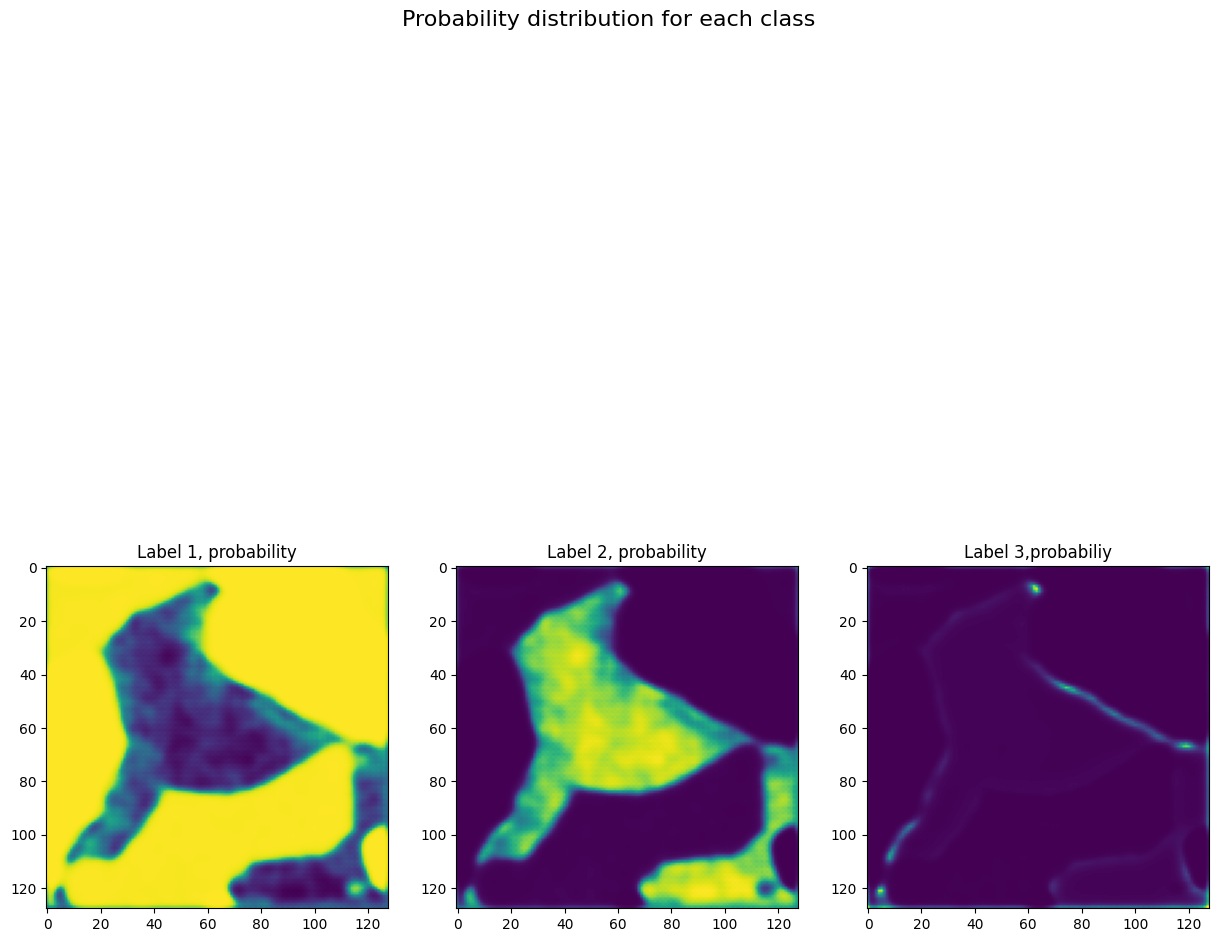

In [ ]:
from torchvision.utils import make_grid
inputs, targets = next(iter(test_loader))
inputs, targets = inputs.to(device), targets.to(device)

outputs = net(inputs)
_, predicted = torch.max(outputs.data, 1)

un_target=targets.unique()
# Compute loss.
targets[targets==un_target[0]]=0
targets[targets==un_target[1]]=1
targets[targets==un_target[2]]=2

targets = targets.to(torch.int64)

fig,axs = plt.subplots(1,3,figsize=(15,15))

axs[0].imshow(output.detach().cpu().numpy()[0,0,:,:])
axs[0].set_title('Label 1, probability')
axs[1].imshow(output.detach().cpu().numpy()[0,1,:,:])
axs[1].set_title('Label 2, probability')
axs[2].imshow(output.detach().cpu().numpy()[0,2,:,:])
axs[2].set_title('Label 3,probabiliy')
fig.suptitle('Probability distribution for each class', fontsize=16)
plt.show()


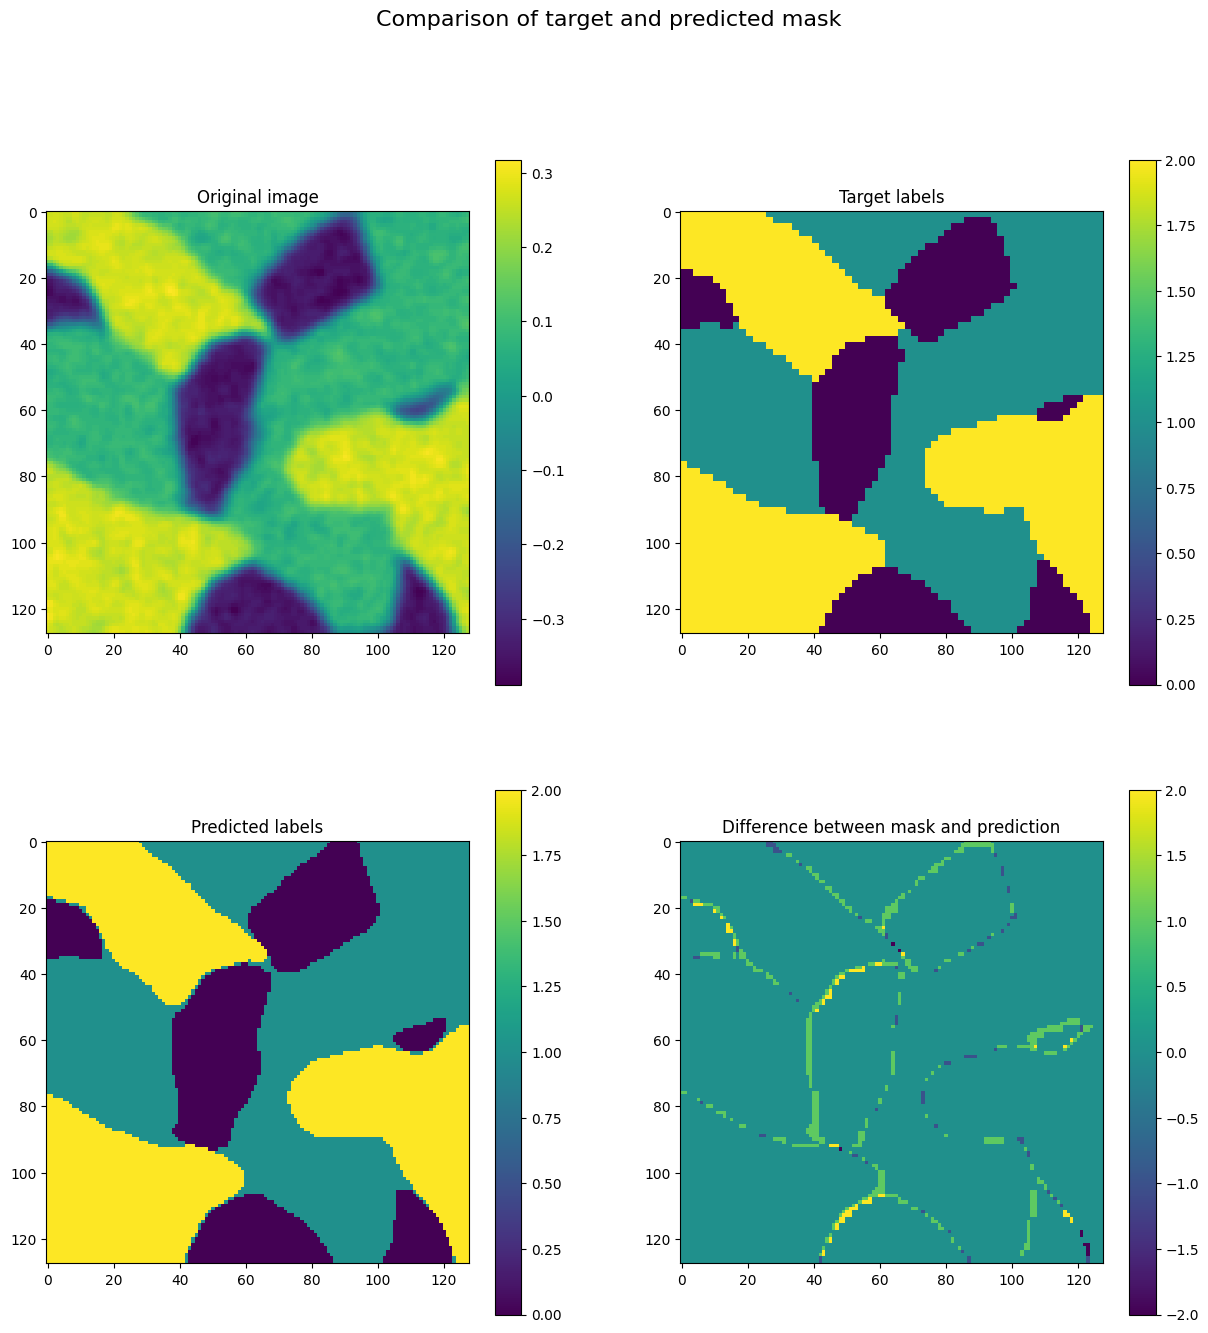

In [ ]:
fig,axs=plt.subplots(2,2,figsize=(15,15))
im1=axs[1,0].imshow(predicted[0,:,:].cpu())
axs[1,0].set_title('Predicted labels')
plt.colorbar(im1, ax=axs[1, 0])
targets = targets.to(torch.int64) [0,:,:]
im2=axs[0,1].imshow(targets.cpu())
axs[0,1].set_title('Target labels')
plt.colorbar(im2, ax=axs[0,1])
im3=axs[0,0].imshow(inputs[0,0,:,:].cpu())
axs[0,0].set_title('Original image')
plt.colorbar(im3, ax=axs[0,0])
im4=axs[1,1].imshow(targets.cpu()-predicted[0,:,:].cpu())
axs[1,1].set_title('Difference between mask and prediction')
plt.colorbar(im4, ax=axs[1,1])

fig.suptitle('Comparison of target and predicted mask', fontsize=16)
plt.show()

## Determining the optimal training set size through experimentation


In [ ]:
'''
This function evaluates the model on a validation set.
It calculates the
    - Dice coefficient,
    - Jaccard index,
    - pixel-wise accuracy for the model's predictions
'''
def evaluate_model(model, val_loader, device):
    model.eval()  # Set the model to evaluation mode

    # Initialize metrics
    total_dice = 0
    total_jaccard = 0
    total_pixel_accuracy = 0
    num_batches = 0

    with torch.no_grad():  # No need to track gradients
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)

            # Convert targets according to unique values
            un_target = targets.unique()
            targets[targets == un_target[0]] = 0
            targets[targets == un_target[1]] = 1
            targets[targets == un_target[2]] = 2
            targets = targets.to(torch.int64)

            # Get predictions
            predictions = outputs.max(1)[1]

            # Update metrics
            total_dice += dice(predictions, targets).item()
            total_jaccard += jaccard(predictions, targets).item()
            total_pixel_accuracy += accuracy(predictions, targets).item()
            num_batches += 1

    # Calculate average metrics
    avg_dice = total_dice / num_batches
    avg_jaccard = total_jaccard / num_batches
    avg_pixel_accuracy = total_pixel_accuracy / num_batches

    return avg_dice, avg_jaccard, avg_pixel_accuracy


In [ ]:
# Define a range of training sizes to experiment with
# Works by generating an array of numbers evenly spaced between two specified values
training_sizes = np.linspace(0.1, 0.9, 10)  # For example, 10% to 100% of the training data
# print(training_sizes)

# Initialize lists to store metrics for each training size
training_size_results = {
    "size": [],
    "validation_accuracy_dice": [],
    "validation_accuracy_jaccard": [],
    "validation_accuracy_pixel": []
}

num_images = len(SOC_dataset)
print(f"Number of images in the dataset: {num_images}")


for train_size in training_sizes:
    # Split the dataset according to the current training size
    train_size_actual = int(train_size * len(SOC_dataset))
    train_indices, remaining_indices = train_test_split(
        range(len(SOC_dataset)),
        train_size=train_size_actual,
        random_state=SEED
    )

    # Further split the remaining data into validation and test sets
    val_indices, test_indices = train_test_split(
        remaining_indices,
        test_size=0.5,
        random_state=SEED
    )

    # Create data subsets for each split
    train_split = Subset(SOC_dataset, train_indices)
    val_split = Subset(SOC_dataset, val_indices)
    test_split = Subset(SOC_dataset, test_indices)

    # DataLoader setup
    train_loader = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_split, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_split, batch_size=BATCH_SIZE)

    # Reinitialize the model and optimizer
    net = UNet(n_class=3).to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.0001)

    # Train the model (using the above training loop)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)

    jaccard=JaccardIndex(task="multiclass", num_classes=3).to(device)
    accuracy=MulticlassAccuracy(num_classes=3).to(device)
    batch_size = 16
    num_epochs = 25 #changing the num_epochs from 2 to 12
    validation_every_steps = 10

    step = 0
    net.train()

    train_accuracies_jaccard = []
    train_accuracies_dice = []
    train_accuracies_pixel = []
    valid_accuracies_jaccard = []
    valid_accuracies_dice = []
    valid_accuracies_pixel = []

    for epoch in range(num_epochs):

        train_accuracies_batches_jaccard = []
        train_accuracies_batches_dice = []
        train_accuracies_batches_pixel = []

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass, compute gradients, perform one training step.
            # Your code here!
            # Forward pass.
            output = net(inputs)

            un_target=targets.unique()
            # Compute loss.
            targets[targets==un_target[0]]=0
            targets[targets==un_target[1]]=1
            targets[targets==un_target[2]]=2

            targets = targets.to(torch.int64)

            loss = loss_fn(output, targets)

            # Clean up gradients from the model.
            optimizer.zero_grad()

            # Compute gradients based on the loss from the current batch (backpropagation).
            loss.backward()

            # Take one optimizer step using the gradients computed in the previous step.
            optimizer.step()

            # Increment step counter
            step += 1

            # Compute accuracy.
            predictions = torch.argmax(output,dim=1)
            train_accuracies_batches_dice.append(dice(predictions,targets).cpu())
            train_accuracies_batches_jaccard.append(jaccard(predictions,targets).cpu())
            train_accuracies_batches_pixel.append(accuracy(predictions,targets).cpu())

            if step % validation_every_steps == 0:

                # Append average training accuracy to list.
                train_accuracies_jaccard.append(np.mean(train_accuracies_batches_jaccard))
                train_accuracies_dice.append(np.mean(train_accuracies_batches_dice))
                train_accuracies_pixel.append(np.mean(train_accuracies_batches_pixel))

                train_accuracies_batches_jaccard = []
                train_accuracies_batches_dice = []
                train_accuracies_batches_pixel = []

                # Compute accuracies on validation set.
                valid_accuracies_batches_jaccard = []
                valid_accuracies_batches_dice = []
                valid_accuracies_batches_pixel = []
                with torch.no_grad():
                    net.eval()
                    for inputs, targets in test_loader: # Change to val_loader from test_loader
                        inputs, targets = inputs.to(device), targets.to(device)
                        output = net(inputs)

                        un_target=targets.unique()
                        # Compute loss.
                        targets[targets==un_target[0]]=0
                        targets[targets==un_target[1]]=1
                        targets[targets==un_target[2]]=2

                        targets = targets.to(torch.int64)

                        loss = loss_fn(output, targets)

                        predictions = output.max(1)[1]
                        # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                        valid_accuracies_batches_dice.append(dice(predictions,targets).cpu())
                        valid_accuracies_batches_jaccard.append(jaccard(predictions,targets).cpu())
                        valid_accuracies_batches_pixel.append(accuracy(predictions,targets).cpu())

                    net.train()

                # Append average validation accuracy to list.
                valid_accuracies_jaccard.append(np.mean(valid_accuracies_batches_jaccard))
                valid_accuracies_dice.append(np.mean(valid_accuracies_batches_dice))
                valid_accuracies_pixel.append(np.mean(valid_accuracies_batches_pixel))

                print(f"Step {step:<5}   training accuracy with jaccard: {train_accuracies_jaccard[-1]}")
                print(f"             training accuracy with dice: {train_accuracies_dice[-1]}")
                print(f"             training accuracy with pixel by pixel: {train_accuracies_pixel[-1]}")
                print(f"             test accuracy with jaccard: {valid_accuracies_jaccard[-1]}")
                print(f"             test accuracy with dice: {valid_accuracies_dice[-1]}")
                print(f"             test accuracy with pixel by pixel: {valid_accuracies_pixel[-1]}")

    # Evaluate on the validation set
    val_dice, val_jaccard, val_pixel = evaluate_model(net, val_loader, device)

    # Store the results
    training_size_results["size"].append(train_size)
    training_size_results["validation_accuracy_dice"].append(val_dice)
    training_size_results["validation_accuracy_jaccard"].append(val_jaccard)
    training_size_results["validation_accuracy_pixel"].append(val_pixel)

    print("Finished training.")







Number of images in the dataset: 300
Step 10      training accuracy with jaccard: 0.4312741160392761
             training accuracy with dice: 0.5514951348304749
             training accuracy with pixel by pixel: 0.6290756464004517
             test accuracy with jaccard: 0.40008091926574707
             test accuracy with dice: 0.5420430898666382
             test accuracy with pixel by pixel: 0.622698962688446
Step 20      training accuracy with jaccard: 0.43402016162872314
             training accuracy with dice: 0.5785146355628967
             training accuracy with pixel by pixel: 0.6611578464508057
             test accuracy with jaccard: 0.39560019969940186
             test accuracy with dice: 0.5475194454193115
             test accuracy with pixel by pixel: 0.6348375082015991
Step 30      training accuracy with jaccard: 0.49585700035095215
             training accuracy with dice: 0.6922277808189392
             training accuracy with pixel by pixel: 0.6395152807235718
    

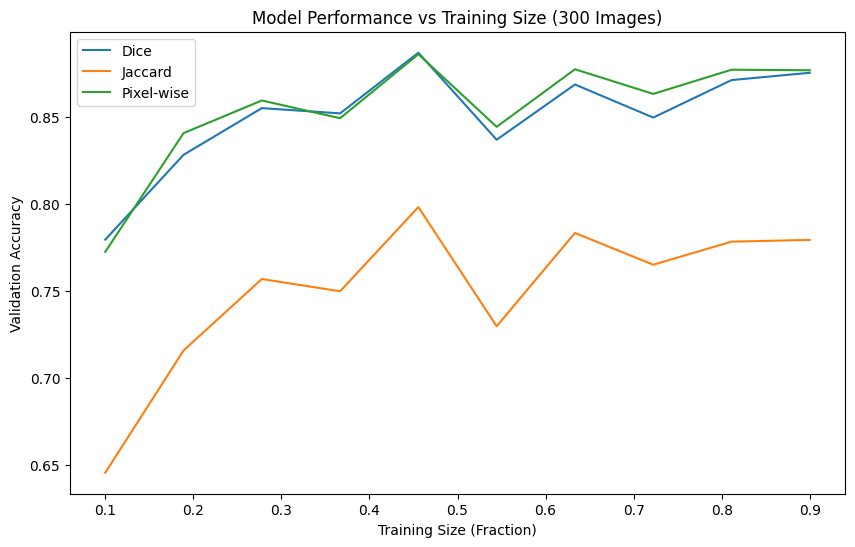

In [ ]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(training_size_results["size"], training_size_results["validation_accuracy_dice"], label='Dice')
plt.plot(training_size_results["size"], training_size_results["validation_accuracy_jaccard"], label='Jaccard')
plt.plot(training_size_results["size"], training_size_results["validation_accuracy_pixel"], label='Pixel-wise')
plt.xlabel('Training Size (Fraction)')
plt.ylabel('Validation Accuracy')
plt.title('Model Performance vs Training Size (300 Images)')
plt.legend()
plt.show()

In [ ]:
print('Accuracies:')

for i, size in enumerate(training_size_results["size"]):
  print()
  print(f"\nTraining Size: {size}")
  print(f"Dice Accuracy: {training_size_results['validation_accuracy_dice'][i]}")
  print(f"Jaccard Accuracy: {training_size_results['validation_accuracy_jaccard'][i]}")
  print(f"Pixel Accuracy: {training_size_results['validation_accuracy_pixel'][i]}")



Accuracies:


Training Size: 0.1
Dice Accuracy: 0.7794856694009569
Jaccard Accuracy: 0.6453794307178922
Pixel Accuracy: 0.7724454005559286


Training Size: 0.18888888888888888
Dice Accuracy: 0.8282730132341385
Jaccard Accuracy: 0.715687669813633
Pixel Accuracy: 0.8407689407467842


Training Size: 0.2777777777777778
Dice Accuracy: 0.8551537649972099
Jaccard Accuracy: 0.7568285380090986
Pixel Accuracy: 0.8595533967018127


Training Size: 0.3666666666666667
Dice Accuracy: 0.8521367410818735
Jaccard Accuracy: 0.7497806251049042
Pixel Accuracy: 0.8493472735087076


Training Size: 0.4555555555555556
Dice Accuracy: 0.887030283610026
Jaccard Accuracy: 0.7982227603594462
Pixel Accuracy: 0.8861637115478516


Training Size: 0.5444444444444445
Dice Accuracy: 0.836956787109375
Jaccard Accuracy: 0.7296479344367981
Pixel Accuracy: 0.8443887829780579


Training Size: 0.6333333333333333
Dice Accuracy: 0.8687419891357422
Jaccard Accuracy: 0.7833259850740433
Pixel Accuracy: 0.8775172382593155


Training 

### 100-Image Results:
In the pursuit of optimizing the training size for our model, we conducted a series of experiments to understand how different training sizes impact the model's accuracy in generalization during the validation phase. This investigation is crucial for efficient resource allocation and achieving the highest possible accuracy with the available data.   
<br>
We incrementally increased the training size from 10% to 90% of our dataset, evaluating the model's performance at each stage using Dice, Jaccard, and Pixel accuracy measurements. These metrics were selected for their relevance in assessing the model's ability to generalize across different aspects of the data.   
<br>
The results indicated a non-linear relationship between training size and validation accuracy. Initially, at a training size of 10%, the model showed moderate accuracy (Dice: 0.647, Jaccard: 0.438, Pixel: 0.597). As the training size increased to approximately 19%, there was a notable improvement in all metrics (Dice: 0.820, Jaccard: 0.705, Pixel: 0.837).   
<br>
Observing a training size of 54% and beyond, the model consistently demonstrates high accuracy. The peak performance in our model is observed at a training size of approximately 81% (Dice: 0.970, Jaccard: 0.941, Pixel: 0.968). Beyond this point, increasing the training size to 90% resulted in a slight decrease in all accuracies. This decrease in performance at 90% training size is attributed to overfitting.   
<br>
The determination of the optimal training size is a critical step in model development. Insufficient training data fails to capture the underlying patterns effectively. However, excessively large training sets may lead to overfitting. For our specific model and dataset, a training size around 81% strikes the optimal balance, achieving the highest generalization accuracy in the validation phase.   
<br>
Accuracies:


Training Size: 0.1
Dice Accuracy: 0.6474103728930155
Jaccard Accuracy: 0.4376014272371928
Pixel Accuracy: 0.5971554120381674


Training Size: 0.18888888888888888
Dice Accuracy: 0.8197052478790283
Jaccard Accuracy: 0.7053113778432211
Pixel Accuracy: 0.8366283377011617


Training Size: 0.2777777777777778
Dice Accuracy: 0.7244427998860677
Jaccard Accuracy: 0.4978529413541158
Pixel Accuracy: 0.6413360039393107


Training Size: 0.3666666666666667
Dice Accuracy: 0.7963237762451172
Jaccard Accuracy: 0.6682008802890778
Pixel Accuracy: 0.8253566026687622


Training Size: 0.4555555555555556
Dice Accuracy: 0.8524013757705688
Jaccard Accuracy: 0.7476776540279388
Pixel Accuracy: 0.8573448956012726


Training Size: 0.5444444444444445
Dice Accuracy: 0.8889171183109283
Jaccard Accuracy: 0.8062330484390259
Pixel Accuracy: 0.8896738290786743


Training Size: 0.6333333333333333
Dice Accuracy: 0.9256801605224609
Jaccard Accuracy: 0.8675453066825867
Pixel Accuracy: 0.9280980229377747


Training Size: 0.7222222222222222
Dice Accuracy: 0.8814871907234192
Jaccard Accuracy: 0.7953358888626099
Pixel Accuracy: 0.8862576484680176


Training Size: 0.8111111111111111
Dice Accuracy: 0.9700385332107544
Jaccard Accuracy: 0.940636157989502
Pixel Accuracy: 0.9681285619735718


Training Size: 0.9
Dice Accuracy: 0.94403076171875
Jaccard Accuracy: 0.8944178819656372
Pixel Accuracy: 0.9343634843826294
<br>
<br>

### 400-Image Results
Accuracies:


Training Size: 0.1
Dice Accuracy: 0.8631207148234049
Jaccard Accuracy: 0.7643282115459442
Pixel Accuracy: 0.8693499763806661


Training Size: 0.18888888888888888
Dice Accuracy: 0.7931535894220526
Jaccard Accuracy: 0.6642078269611705
Pixel Accuracy: 0.8138773007826372


Training Size: 0.2777777777777778
Dice Accuracy: 0.8580767313639323
Jaccard Accuracy: 0.7607222530576918
Pixel Accuracy: 0.8609042829937406


Training Size: 0.3666666666666667
Dice Accuracy: 0.8509661704301834
Jaccard Accuracy: 0.7444576397538185
Pixel Accuracy: 0.8587836474180222


Training Size: 0.4555555555555556
Dice Accuracy: 0.8901330743517194
Jaccard Accuracy: 0.809856789452689
Pixel Accuracy: 0.8935517839023045


Training Size: 0.5444444444444445
Dice Accuracy: 0.8842563033103943
Jaccard Accuracy: 0.7963451445102692
Pixel Accuracy: 0.885801355044047


Training Size: 0.6333333333333333
Dice Accuracy: 0.9226073384284973
Jaccard Accuracy: 0.8587210178375244
Pixel Accuracy: 0.9150137662887573


Training Size: 0.7222222222222222
Dice Accuracy: 0.9310932159423828
Jaccard Accuracy: 0.8778435438871384
Pixel Accuracy: 0.9320302903652191


Training Size: 0.8111111111111111
Dice Accuracy: 0.954217274983724
Jaccard Accuracy: 0.91546763976415
Pixel Accuracy: 0.9542289574941


Training Size: 0.9
Dice Accuracy: 0.9229698181152344
Jaccard Accuracy: 0.8630606830120087
Pixel Accuracy: 0.924077033996582

## Determining the optimal number of images to load into SOC Dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torch

# Assuming SOC_dataset, UNet, dice, jaccard, accuracy, and loss_fn are defined

# Define the total number of images and the subset sizes you want to test
total_images = 500
subset_sizes = [50, 100, 200, 300, 400, 500]  # Example subset sizes

# Initialize a dictionary to store the results
results = {
    "subset_size": [],
    "validation_accuracy_dice": [],
    "validation_accuracy_jaccard": [],
    "validation_accuracy_pixel": []
}

for size in subset_sizes:
    # Select a random subset of the dataset
    subset_indices = np.random.choice(range(len(SOC_dataset)), size, replace=False)
    dataset_subset = Subset(SOC_dataset, subset_indices)

    # Split the subset into training and validation
    train_indices, val_indices = train_test_split(range(len(dataset_subset)), test_size=0.2)
    train_subset = Subset(dataset_subset, train_indices)
    val_subset = Subset(dataset_subset, val_indices)

    # DataLoader setup
    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE)

    # Initialize the model, loss function, and optimizer
    net = UNet(n_class=3).to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.0001)

    # Train the model (using the above training loop)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)

    jaccard=JaccardIndex(task="multiclass", num_classes=3).to(device)
    accuracy=MulticlassAccuracy(num_classes=3).to(device)
    batch_size = 16
    num_epochs = 25 #changing the num_epochs from 2 to 12
    validation_every_steps = 10

    step = 0
    net.train()

    train_accuracies_jaccard = []
    train_accuracies_dice = []
    train_accuracies_pixel = []
    valid_accuracies_jaccard = []
    valid_accuracies_dice = []
    valid_accuracies_pixel = []

    for epoch in range(num_epochs):

        train_accuracies_batches_jaccard = []
        train_accuracies_batches_dice = []
        train_accuracies_batches_pixel = []

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass, compute gradients, perform one training step.
            # Your code here!
            # Forward pass.
            output = net(inputs)

            un_target=targets.unique()
            # Compute loss.
            targets[targets==un_target[0]]=0
            targets[targets==un_target[1]]=1
            targets[targets==un_target[2]]=2

            targets = targets.to(torch.int64)

            loss = loss_fn(output, targets)

            # Clean up gradients from the model.
            optimizer.zero_grad()

            # Compute gradients based on the loss from the current batch (backpropagation).
            loss.backward()

            # Take one optimizer step using the gradients computed in the previous step.
            optimizer.step()

            # Increment step counter
            step += 1

            # Compute accuracy.
            predictions = torch.argmax(output,dim=1)
            train_accuracies_batches_dice.append(dice(predictions,targets).cpu())
            train_accuracies_batches_jaccard.append(jaccard(predictions,targets).cpu())
            train_accuracies_batches_pixel.append(accuracy(predictions,targets).cpu())

            if step % validation_every_steps == 0:

                # Append average training accuracy to list.
                train_accuracies_jaccard.append(np.mean(train_accuracies_batches_jaccard))
                train_accuracies_dice.append(np.mean(train_accuracies_batches_dice))
                train_accuracies_pixel.append(np.mean(train_accuracies_batches_pixel))

                train_accuracies_batches_jaccard = []
                train_accuracies_batches_dice = []
                train_accuracies_batches_pixel = []

                # Compute accuracies on validation set.
                valid_accuracies_batches_jaccard = []
                valid_accuracies_batches_dice = []
                valid_accuracies_batches_pixel = []
                with torch.no_grad():
                    net.eval()
                    for inputs, targets in val_loader:
                        inputs, targets = inputs.to(device), targets.to(device)
                        output = net(inputs)

                        un_target=targets.unique()
                        # Compute loss.
                        targets[targets==un_target[0]]=0
                        targets[targets==un_target[1]]=1
                        targets[targets==un_target[2]]=2

                        targets = targets.to(torch.int64)

                        loss = loss_fn(output, targets)

                        predictions = output.max(1)[1]
                        # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                        valid_accuracies_batches_dice.append(dice(predictions,targets).cpu())
                        valid_accuracies_batches_jaccard.append(jaccard(predictions,targets).cpu())
                        valid_accuracies_batches_pixel.append(accuracy(predictions,targets).cpu())

                    net.train()

                # Append average validation accuracy to list.
                valid_accuracies_jaccard.append(np.mean(valid_accuracies_batches_jaccard))
                valid_accuracies_dice.append(np.mean(valid_accuracies_batches_dice))
                valid_accuracies_pixel.append(np.mean(valid_accuracies_batches_pixel))

                print(f"Step {step:<5}   training accuracy with jaccard: {train_accuracies_jaccard[-1]}")
                print(f"             training accuracy with dice: {train_accuracies_dice[-1]}")
                print(f"             training accuracy with pixel by pixel: {train_accuracies_pixel[-1]}")
                print(f"             test accuracy with jaccard: {valid_accuracies_jaccard[-1]}")
                print(f"             test accuracy with dice: {valid_accuracies_dice[-1]}")
                print(f"             test accuracy with pixel by pixel: {valid_accuracies_pixel[-1]}")



    # Evaluate on the validation set
    val_dice, val_jaccard, val_pixel = evaluate_model(net, val_loader, device)

    # Store the results
    results["subset_size"].append(size)
    results["validation_accuracy_dice"].append(val_dice)
    results["validation_accuracy_jaccard"].append(val_jaccard)
    results["validation_accuracy_pixel"].append(val_pixel)

    print("Finished training.")



Step 10      training accuracy with jaccard: 0.14621607959270477
             training accuracy with dice: 0.4386482238769531
             training accuracy with pixel by pixel: 0.3333333432674408
             test accuracy with jaccard: 0.13434447348117828
             test accuracy with dice: 0.40303343534469604
             test accuracy with pixel by pixel: 0.3333333432674408
Step 20      training accuracy with jaccard: 0.4092727601528168
             training accuracy with dice: 0.6306419372558594
             training accuracy with pixel by pixel: 0.5626779794692993
             test accuracy with jaccard: 0.41440337896347046
             test accuracy with dice: 0.6272643804550171
             test accuracy with pixel by pixel: 0.5715223550796509
Step 30      training accuracy with jaccard: 0.4081362783908844
             training accuracy with dice: 0.601318359375
             training accuracy with pixel by pixel: 0.5732322931289673
             test accuracy with jaccard: 0.4

ValueError: ignored

In [ ]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(results["subset_size"], results["validation_accuracy_dice"], label='Dice')
plt.plot(results["subset_size"], results["validation_accuracy_jaccard"], label='Jaccard')
plt.plot(results["subset_size"], results["validation_accuracy_pixel"], label='Pixel-wise')
plt.xlabel('Number of Images in Training Subset')
plt.ylabel('Validation Accuracy')
plt.title('Model Performance vs Number of Training Images')
plt.legend()
plt.show()

In [ ]:
print('Image Count Accuracies:')

for i, size in enumerate(results["subset_size"]):
  print()
  print(f"\nTraining Size: {size}")
  print(f"Dice Accuracy: {results['validation_accuracy_dice'][i]}")
  print(f"Jaccard Accuracy: {results['validation_accuracy_jaccard'][i]}")
  print(f"Pixel Accuracy: {results['validation_accuracy_pixel'][i]}")

#### No. 1 - Invalid*

Image Count Accuracies:


Training Size: 50
Dice Accuracy: 0.9134887456893921
Jaccard Accuracy: 0.8408966064453125
Pixel Accuracy: 0.9135023355484009


Training Size: 100
Dice Accuracy: 0.8767509460449219
Jaccard Accuracy: 0.7889577746391296
Pixel Accuracy: 0.8776053786277771


Training Size: 200
Dice Accuracy: 0.8014577229817709
Jaccard Accuracy: 0.6841311454772949
Pixel Accuracy: 0.8031443158785502


Training Size: 300
Dice Accuracy: 0.9364255219697952
Jaccard Accuracy: 0.8855397999286652
Pixel Accuracy: 0.9431721121072769


Training Size: 400
Dice Accuracy: 0.9439437866210938
Jaccard Accuracy: 0.8982219219207763
Pixel Accuracy: 0.9460438132286072


Training Size: 500
Dice Accuracy: 0.8803754534040179
Jaccard Accuracy: 0.7955172998564584
Pixel Accuracy: 0.8877144626208714

No.2
Image Count Accuracies:


Training Size: 50
Dice Accuracy: 0.801464855670929
Jaccard Accuracy: 0.6599847674369812
Pixel Accuracy: 0.7638944387435913


Training Size: 100
Dice Accuracy: 0.8519649505615234
Jaccard Accuracy: 0.7521397173404694
Pixel Accuracy: 0.8691247999668121


Training Size: 200
Dice Accuracy: 0.8442535400390625
Jaccard Accuracy: 0.7354564070701599
Pixel Accuracy: 0.8520897428194681


Training Size: 300
Dice Accuracy: 0.9487104415893555
Jaccard Accuracy: 0.9045857787132263
Pixel Accuracy: 0.947684645652771


Training Size: 400
Dice Accuracy: 0.9210350036621093
Jaccard Accuracy: 0.8595059514045715
Pixel Accuracy: 0.9257229566574097


Training Size: 500
Dice Accuracy: 0.9643374851771763
Jaccard Accuracy: 0.9324882200786045
Pixel Accuracy: 0.9632118770054409